# Prepare Moduls, Function, Path, Data


## Imports

In [ ]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import tensorflow as tf
from abc import ABC, abstractmethod
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

from tensorflow.keras.models import Model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import (
    Input,
    Flatten,
    Dense,
    Conv2D,
    Dropout
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## PEP8 standard

In [ ]:
%%capture
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

## Custom packages

In [ ]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [ ]:
import importlib
import path_manager

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,

    ]
)

from path_manager import PathManager

## Setup paths

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 4
COMPETITION_PATH = gdrive_path + 'CrowdCounting/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/CrowdCounting/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/CrowdCounting/Models/trial_4 already exists


## Helper functions

In [ ]:
def visualize_predictions(model_, generator_):
        X_batch, Y_batch = next(generator_)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        predictions = model_.predict(X_batch)
        print(type(predictions), predictions.shape)

        _, ax = plt.subplots(3, 3, figsize=(10, 10))
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(f'Ground truth: {Y_batch[i]}\nPredicted: {predictions[i]}')
            ax[i].axis('off')

        _, ax_hist = plt.subplots()
        ax_hist.hist(Y_batch, label='ground truth labels')
        ax_hist.hist(predictions, label='model predictions'),

        _, ax_predictions = plt.subplots()
        ax_predictions.plot(
            Y_batch,
            predictions,
            linestyle='None',
            marker='o',
            # markerfacecolor='white',
            markersize=3
        )

        min_val = min(np.min(Y_batch), np.min(predictions))
        max_val = max(np.max(Y_batch), np.max(predictions))
        ax_predictions.plot(
            np.arange(int(min_val), int(max_val)),
            np.arange(int(min_val), int(max_val)),
            label='perfect match'
        )
        ax_predictions.set_xlabel('ground_truth')
        ax_predictions.set_ylabel('predictions')
        ax_predictions.grid()
        ax_predictions.legend()

In [ ]:
def save_history(history, target_path_):
    # assert os.path.isdir(target_path_)
    df = pd.DataFrame(history.history)
    df.to_csv(target_path_)

In [ ]:
def plot_history(history_, metrics_):
    _, ax = plt.subplots()
    ax.plot(history_.history[metrics_], label='train')
    ax.plot(history_.history[f'val_{metrics_}'], label='validation')
    ax.grid()
    ax.legend(shadow=True)

In [ ]:
def count_parameters(model):
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)

    return {
        'Total parameters': trainable_count + non_trainable_count,
        'Trainable parameters': trainable_count,
        'Non-trainable parameters': non_trainable_count
    }

In [ ]:
def train_model_with_unfreezed_layers(
    model_class_,
    model_params_dict_,
    optimizer_,
    model_name_,
    n_unfreezed_layers_,
    epochs_,
    to_freeze_=True
):
    model = model_class_(
        name_=f'{model_name_}_{n_unfreezed_layers_}_unfreezed_layers',
        **model_params_dict_,
    )

    model.prepare_model()
    if to_freeze_:
        model.unfreeze_n_layers(n_unfreezed_layers_)
    model.compile_model(optimizer_=optimizer_)

    print(f'Training the model: {model.name}')
    print(f'# unfreezed layers: {n_unfreezed_layers_}')
    print(f'Parameters of model: {count_parameters(model.model)}')

    history = model.fit(
        epochs_=epochs_,
        callbacks_=[
            EarlyStopping(
                monitor='val_mse',
                mode='min',
                patience=5
            ),
            ReduceLROnPlateau(
                monitor='val_mse',
                patience=3,
                factor=0.2,
                min_lr=0.000001
            ),
            ModelCheckpoint(
                filepath=os.path.join(
                    manager.models_trial_path,
                    model.name,
                    model.name
                ),
                save_weights_only=True
            )
        ]
    )
    validation_results = model.model.evaluate(model.validation_generator)
    print(f'Validation results: {validation_results}')
    print('Saving history')

    save_history(
        history,
        os.path.join(manager.models_trial_path, f'{model.name}.csv')
    )

In [ ]:
frames_directory = os.path.join(manager.data_root_path, 'frames')
class NNModel(ABC):
    def __init__(
        self,
        name_,
        input_image_size_,
        validation_split_,
        batch_size_,
        trainval_labels_df_,
        test_labels_df_,
        frames_directory_=frames_directory
    ):
        self.random_state = 42
        self.name = name_
        self.input_image_size = input_image_size_
        self.validation_split = validation_split_
        self.batch_size = batch_size_
        self.frames_directory = frames_directory_


        self.data_generator_parameters = None
        self.train_generator = None
        self.validation_generator = None
        self.test_generator = None
        self.model = None
        self.init_data_generator_parameters()
        self.init_data_generators(
            trainval_labels_df_,
            test_labels_df_
        )

    def __repr__(self):
        return f'''
            {
                self.random_state,
                self.name,
                self.input_image_size,
                self.validation_split,
                self.batch_size
            }
        '''
    @abstractmethod
    def init_data_generator_parameters(self):
        # Augmentation / preprocessing parameters
        pass

    def init_data_generators(
        self,
        trainval_labels_df_,
        test_labels_df_
    ):
        trainval_data_generator = ImageDataGenerator(
            **self.data_generator_parameters,
            validation_split=self.validation_split)

        test_data_generator = ImageDataGenerator(
            **self.data_generator_parameters)

        common_flow_params = dict(
            directory=self.frames_directory,
            x_col='image_name',
            y_col='count',
            target_size=self.input_image_size,
            color_mode='rgb',
            class_mode='raw',
            batch_size=self.batch_size,
            shuffle=True,
            seed=self.random_state
        )

        self.train_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='training',
            dataframe=trainval_labels_df_
        )

        self.validation_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='validation',
            dataframe=trainval_labels_df_
        )

        self.test_generator = test_data_generator.flow_from_dataframe(
            **common_flow_params,
            dataframe=test_labels_df_
        )

    def visualize_data(self):
        X_batch, Y_batch = next(self.train_generator)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        _, ax = plt.subplots(3, 3, figsize=(10, 10))
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(Y_batch[i])
            ax[i].axis('off')

        _, ax_hist = plt.subplots()
        ax_hist.hist(Y_batch)

    @abstractmethod
    def prepare_model(self):
        pass

    def compile_model(
        self,
        optimizer_=tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    ):
        self.model.compile(
            optimizer=optimizer_,  # tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mse', 'mae']
        )

    def unfreeze_n_layers(self, n_layers_to_freeze_):
        assert n_layers_to_freeze_ > 0

        for layer in self.model.layers[:-n_layers_to_freeze_]:
            layer.trainable = False
        for layer in self.model.layers[-n_layers_to_freeze_:]:
            layer.trainable = True

    def fit(self, epochs_, callbacks_):
        self.learning_history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        # print(f'Saving history')
        # save_history(
        #     history,
        #     os.path.join(
        #         manager.models_trial_path, f'{self.name}.csv'
        #     )
        # )
        return self.learning_history

## Data Preparation

In [ ]:
len(os.listdir(os.path.join(manager.data_root_path, 'frames')))

2000

In [ ]:
# Frames Directory
frames_directory = os.path.join(manager.data_root_path, 'frames')
labels_df = pd.read_csv(os.path.join(manager.data_root_path, 'labels.csv'))
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
print(labels_df.head(1))

   id  count      image_name
0   1     35  seq_000001.jpg


In [ ]:
frames = os.listdir(os.path.join(manager.data_root_path, 'frames'))

seq_000982.jpg
seq_000999.jpg
seq_001004.jpg
seq_001014.jpg


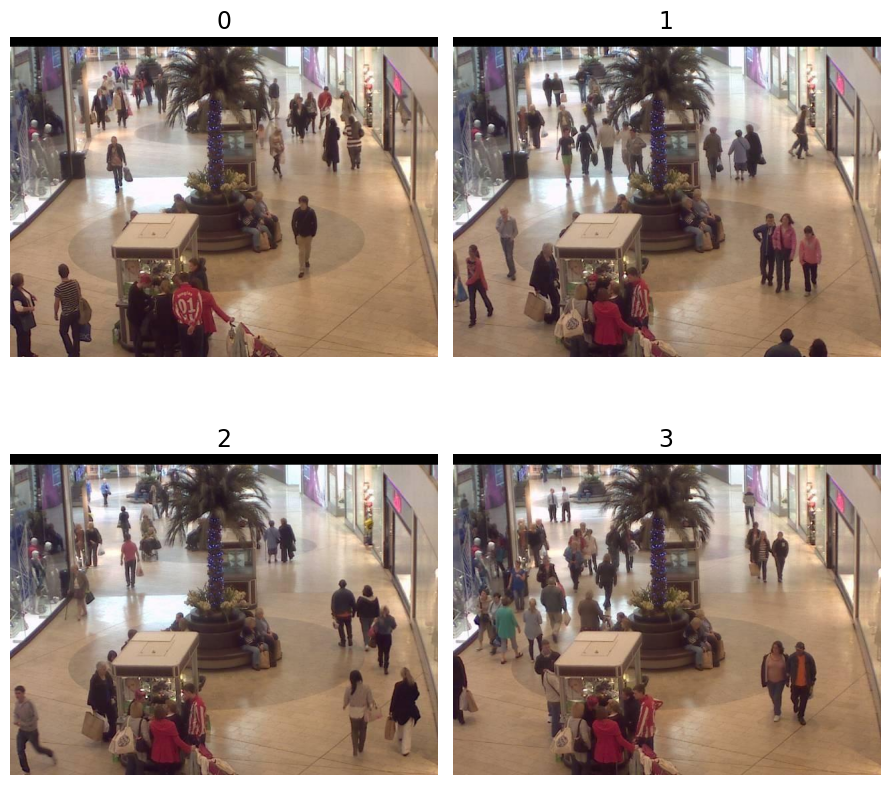

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(9, 9))
ax = ax.flatten()

for idx, frame in enumerate(sorted(frames[:4])):
    img = mpimg.imread(
        os.path.join(
            manager.data_root_path,
            'frames',
            frame  # 'seq_001006.jpg'
        )
    )
    print(frame)
    ax[idx].imshow(img)
    ax[idx].set_title(idx, fontsize=17)
    ax[idx].axis('off')

plt.tight_layout()

In [ ]:
TRAINVAL_SIZE = 0.8
RANDOM_STATE = 42

trainval_labels_df, test_labels_df = train_test_split(
    labels_df,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
)
trainval_labels_df.shape, test_labels_df.shape

((1600, 3), (400, 3))

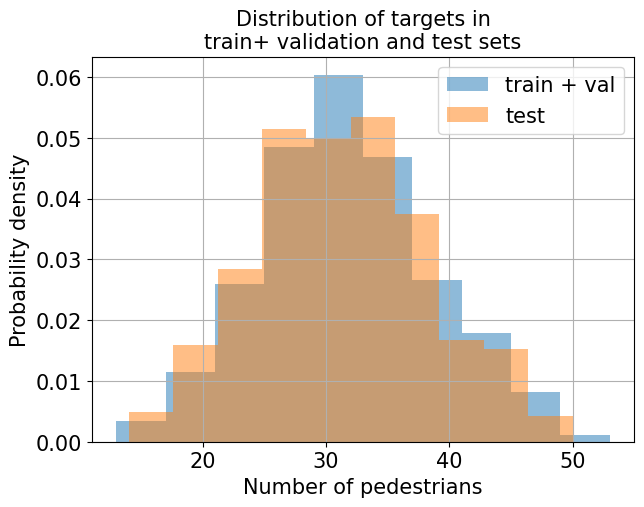

In [ ]:
fontsize = 15

_, ax = plt.subplots(figsize=(7, 5))
ax.hist(trainval_labels_df['count'], density=True, label='train + val', alpha=0.5)
ax.hist(test_labels_df['count'], density=True, label='test', alpha=0.5)
ax.set_xlabel(f'Number of pedestrians', fontsize=fontsize)
ax.set_ylabel(f'Probability density', fontsize=fontsize)
ax.set_title(f'Distribution of targets in\ntrain+ validation and test sets', fontsize=fontsize)
ax.grid()
ax.legend(prop={'size': fontsize})
ax.tick_params(labelsize=15)

# Baseline Models Training

## Xception

### Prepare and train model

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionModel(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):

        self.data_generator_parameters = dict(
            rescale=None,  # 1./255,
            preprocessing_function=tf.keras.applications.xception.preprocess_input
        )

    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
xception = XceptionModel(
    name_='xception',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
xception.prepare_model()
xception.unfreeze_n_layers(7)
xception.compile_model()

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
history_xception = xception.fit(
    epochs_=50,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=5
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
           filepath=os.path.join(
               manager.models_trial_path,
               xception.name,
               xception.name
             ),
             save_weights_only=True
         )
    ]
)

In [ ]:
xception.model.evaluate(xception.validation_generator)

In [ ]:
xception.model.summary()

### Save data

In [ ]:
save_history(history_xception, os.path.join(manager.models_trial_path, f'{xception.name}.csv'))

## ResNet50

### Create and train the model

In [ ]:
class ResNetModel(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):

        self.data_generator_parameters = dict(
            rescale=None,  # 1./255,
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

    def prepare_model(self):
        feature_extractor = resnet50.ResNet50(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
resnet = ResNetModel(
    name_='resnet',
    input_image_size_=(224, 224),
    validation_split_=0.2,  # fraction of images, reserved for validation
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

print(repr(resnet))
resnet.prepare_model()

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.

            (42, 'resnet', (224, 224), 0.2, 64)
        
94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
resnet.unfreeze_n_layers(7)
resnet.compile_model()

In [ ]:
history = resnet.fit(
    epochs_=50,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                resnet.name,
                resnet.name
            ),
            save_weights_only=True
        )
    ]
)

Epoch 1/50
20/20 [==============================] - 27s 811ms/step - loss: 170.8930 - mse: 170.8930 - mae: 10.1783 - val_loss: 32.1502 - val_mse: 32.1502 - val_mae: 4.5598 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 17s 809ms/step - loss: 46.3562 - mse: 46.3562 - mae: 5.4317 - val_loss: 28.3887 - val_mse: 28.3887 - val_mae: 4.1750 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 15s 753ms/step - loss: 32.2361 - mse: 32.2361 - mae: 4.4972 - val_loss: 18.3197 - val_mse: 18.3197 - val_mae: 3.3108 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 13s 656ms/step - loss: 25.2557 - mse: 25.2557 - mae: 3.9348 - val_loss: 14.9742 - val_mse: 14.9742 - val_mae: 2.9977 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 13s 649ms/step - loss: 23.8061 - mse: 23.8061 - mae: 3.8184 - val_loss: 14.4563 - val_mse: 14.4563 - val_mae: 2.9288 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 13s 671ms/step - loss: 22.8157 - ms

In [ ]:
resnet.model.evaluate(resnet.validation_generator)

5/5 [==============================] - 2s 421ms/step - loss: 12.3364 - mse: 12.3364 - mae: 2.8113


[12.336390495300293, 12.336390495300293, 2.811321258544922]

In [ ]:
resnet.model.summary()

### Save learning history

In [ ]:
save_history(history, os.path.join(manager.models_trial_path, f'{resnet.name}.csv'))

## Inception v3

### Create and train the model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


class InceptionV3Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):

        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
        )

    def prepare_model(self):
        feature_extractor = InceptionV3(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
inception_v3 = InceptionV3Model(
    name_='inception_v3',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

In [ ]:
inception_v3.prepare_model()
inception_v3.unfreeze_n_layers(7)
inception_v3.compile_model()

In [ ]:
history_inception_v3 = inception_v3.fit(
    epochs_=50,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                inception_v3.name,
                inception_v3.name
            ),
            save_weights_only=True
        )
    ]
)

In [ ]:
inception_v3.model.evaluate(inception_v3.validation_generator)

### Save data

In [ ]:
save_history(history_inception_v3, os.path.join(manager.models_trial_path, f'{inception_v3.name}.csv'))

## Inception resnet V2

### Create and train the model

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


class InceptionResnetV2Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):

        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.\
                keras.\
                applications.\
                inception_resnet_v2.\
                preprocess_input
        )

    def prepare_model(self):
        feature_extractor = InceptionResNetV2(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
inception_resnet_v2 = InceptionResnetV2Model(
    name_='inception_resnet_v2',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
inception_resnet_v2.prepare_model()
inception_resnet_v2.unfreeze_n_layers(7)
inception_resnet_v2.compile_model()

219055592/219055592 [==============================] - 7s 0us/step


In [ ]:
inception_resnet_v2_history = inception_resnet_v2.fit(
    epochs_=50,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                inception_resnet_v2.name,
                inception_resnet_v2.name
            ),
            save_weights_only=True
        )
    ]
)

Epoch 1/50
20/20 [==============================] - 39s 1s/step - loss: 855.2911 - mse: 855.2911 - mae: 28.3158 - val_loss: 667.5573 - val_mse: 667.5573 - val_mae: 24.9845 - lr: 8.0000e-06
Epoch 2/50
20/20 [==============================] - 18s 876ms/step - loss: 504.6057 - mse: 504.6057 - mae: 21.1189 - val_loss: 327.3834 - val_mse: 327.3834 - val_mae: 16.7838 - lr: 8.0000e-06
Epoch 3/50
20/20 [==============================] - 18s 870ms/step - loss: 230.8219 - mse: 230.8219 - mae: 13.3264 - val_loss: 123.1570 - val_mse: 123.1570 - val_mae: 9.2779 - lr: 8.0000e-06
Epoch 4/50
20/20 [==============================] - 19s 917ms/step - loss: 98.3291 - mse: 98.3291 - mae: 8.0544 - val_loss: 58.6231 - val_mse: 58.6231 - val_mae: 6.0473 - lr: 8.0000e-06
Epoch 5/50
20/20 [==============================] - 19s 929ms/step - loss: 71.5641 - mse: 71.5641 - mae: 6.7877 - val_loss: 52.8471 - val_mse: 52.8471 - val_mae: 5.7433 - lr: 8.0000e-06
Epoch 6/50
20/20 [==============================] - 18s 

In [ ]:
inception_resnet_v2.model.evaluate(inception_resnet_v2.validation_generator)

5/5 [==============================] - 4s 640ms/step - loss: 31.6155 - mse: 31.6155 - mae: 4.4992


[31.615467071533203, 31.615467071533203, 4.499157428741455]

### Save data

In [ ]:
save_history(inception_resnet_v2_history, os.path.join(manager.models_trial_path, f'{inception_resnet_v2.name}.csv'))

## VGG16

### Prepare and train model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16


class VGG16Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        print(f'VGG16: init data generator parameters')
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.vgg16.preprocess_input
        )

    def prepare_model(self):
        feature_extractor = VGG16(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
vgg16 = VGG16Model(
    name_='vgg16',
    input_image_size_=(224, 224),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

print(repr(vgg16))

VGG16: init data generator parameters
Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.

            (42, 'vgg16', (224, 224), 0.2, 64)
        


In [ ]:
vgg16.prepare_model()
vgg16.unfreeze_n_layers(7)
vgg16.compile_model()

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_history = vgg16.fit(
    epochs_=50,
    callbacks_=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                vgg16.name,
                vgg16.name
            ),
            save_weights_only=True
        )
    ]
)

Epoch 1/50
20/20 [==============================] - 24s 624ms/step - loss: 832.2424 - mse: 832.2424 - mae: 27.6982 - val_loss: 488.6282 - val_mse: 488.6282 - val_mae: 21.2250 - lr: 8.0000e-06
Epoch 2/50
20/20 [==============================] - 15s 750ms/step - loss: 314.3003 - mse: 314.3003 - mae: 15.8859 - val_loss: 140.7426 - val_mse: 140.7426 - val_mae: 10.4464 - lr: 8.0000e-06
Epoch 3/50
20/20 [==============================] - 13s 630ms/step - loss: 108.9749 - mse: 108.9749 - mae: 8.3684 - val_loss: 45.6969 - val_mse: 45.6969 - val_mae: 5.3672 - lr: 8.0000e-06
Epoch 4/50
20/20 [==============================] - 13s 630ms/step - loss: 66.9866 - mse: 66.9866 - mae: 6.5679 - val_loss: 35.4184 - val_mse: 35.4184 - val_mae: 4.7271 - lr: 8.0000e-06
Epoch 5/50
20/20 [==============================] - 13s 635ms/step - loss: 61.3919 - mse: 61.3919 - mae: 6.2088 - val_loss: 34.2850 - val_mse: 34.2850 - val_mae: 4.6620 - lr: 8.0000e-06
Epoch 6/50
20/20 [==============================] - 13s 

In [ ]:
vgg16.model.evaluate(vgg16.validation_generator)

5/5 [==============================] - 2s 428ms/step - loss: 13.3606 - mse: 13.3606 - mae: 2.9024


[13.360641479492188, 13.360641479492188, 2.902391195297241]

### Save learning history

In [ ]:
save_history(
    vgg16_history,
    os.path.join(
        manager.models_trial_path,
        f'{vgg16.name}.csv'
    )
)

## VGG19

### Prepare and train model

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19


class VGG19Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=\
                tf.keras.applications.vgg19.preprocess_input
        )

    def prepare_model(self):
        feature_extractor = VGG19(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
vgg19 = VGG19Model(
    name_='vgg19',
    input_image_size_=(224, 224),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

print(repr(vgg19))

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.

            (42, 'vgg19', (224, 224), 0.2, 64)
        


In [ ]:
vgg19.prepare_model()
vgg19.unfreeze_n_layers(7)
vgg19.compile_model()

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg19_history = vgg19.fit(
    epochs_=50,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            save_weights_only=True,
            filepath=os.path.join(
                manager.models_trial_path,
                vgg19.name,
                vgg19.name
            )
        )
    ]
)

Epoch 1/50
20/20 [==============================] - 15s 664ms/step - loss: 925.1251 - mse: 925.1251 - mae: 29.0739 - val_loss: 504.1290 - val_mse: 504.1290 - val_mae: 21.3608 - lr: 8.0000e-06
Epoch 2/50
20/20 [==============================] - 13s 627ms/step - loss: 354.6457 - mse: 354.6457 - mae: 16.7724 - val_loss: 153.3224 - val_mse: 153.3224 - val_mae: 10.6510 - lr: 8.0000e-06
Epoch 3/50
20/20 [==============================] - 12s 607ms/step - loss: 126.7831 - mse: 126.7831 - mae: 9.1206 - val_loss: 56.3031 - val_mse: 56.3031 - val_mae: 5.9758 - lr: 8.0000e-06
Epoch 4/50
20/20 [==============================] - 13s 643ms/step - loss: 75.5780 - mse: 75.5780 - mae: 6.9296 - val_loss: 47.8763 - val_mse: 47.8763 - val_mae: 5.5803 - lr: 8.0000e-06
Epoch 5/50
20/20 [==============================] - 13s 652ms/step - loss: 73.6829 - mse: 73.6829 - mae: 6.8230 - val_loss: 46.3373 - val_mse: 46.3373 - val_mae: 5.4967 - lr: 8.0000e-06
Epoch 6/50
20/20 [==============================] - 13s 

In [ ]:
vgg19.model.evaluate(vgg19.validation_generator)

5/5 [==============================] - 3s 457ms/step - loss: 17.5642 - mse: 17.5642 - mae: 3.2782


[17.564167022705078, 17.564167022705078, 3.2781646251678467]

### Save learning history

In [ ]:
save_history(
    vgg19_history,
    os.path.join(
        manager.models_trial_path,
        f'{vgg19.name}.csv'
    )
)

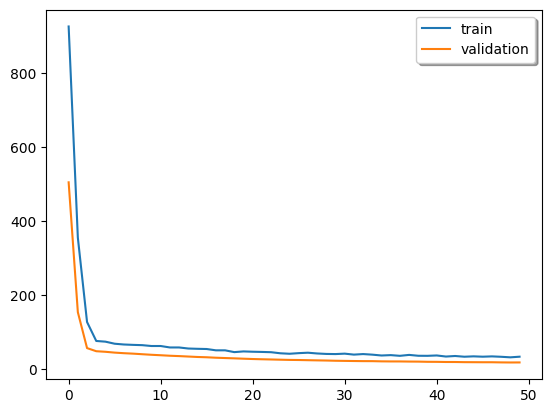

In [ ]:
_, ax = plt.subplots()
ax.plot(vgg19_history.history['loss'], label='train')
ax.plot(vgg19_history.history['val_loss'], label='validation')
ax.legend(shadow=True)

In [ ]:
_, ax = plt.subplots(5, 5, figsize=(25, 25))
ax = ax.flatten()
for i in range(1):
    x, y = resnet.validation_generator[i]
    print(x.shape, y.shape)
    predictions = resnet.model.predict(x)
    for j in range(25):
        ax[j].imshow(x[j])
        ax[j].set_title(f'{y[j]} VS {predictions[j]}')
    plt.tight_layout()

#Xception Model Different Training Settings

## Xception Generalization ability VS number of unfreezed layers

In [ ]:
# Total number of layers
x = XceptionModel(
    name_='xception',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)
x.prepare_model()
print(len(x.model.layers))

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
138


In [ ]:
common_function_parameters = dict(
    model_class_=XceptionModel,
    model_name_='xception',
    model_params_dict_=dict(
        input_image_size_=(299, 299),
        validation_split_=0.2,
        batch_size_=64,
        trainval_labels_df_=trainval_labels_df,
        test_labels_df_=test_labels_df
    ),
    epochs_=50
)

### 10 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    n_unfreezed_layers_=10,
    # to_freeze_=False
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_10_unfreezed_layers
# unfreezed layers: 10
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 4144049, 'Non-trainable parameters': 17697832}
Epoch 1/50
20/20 [==============================] - 485s 25s/step - loss: 229.3291 - mse: 229.3291 - mae: 11.6747 - val_loss: 1447.6062 - val_mse: 1447.6062 - val_mae: 37.2183 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 14s 693ms/step - loss: 29.1534 - mse: 29.1534 - mae: 4.2667 - val_loss: 473.3749 - val_mse: 473.3749 - val_mae: 21.1224 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 14s 715ms/step - loss: 18.2540 - mse: 18.2540 - mae: 3.3867 - val_loss: 183.2693 - val_mse: 183.2693 - val_mae: 12.9535 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 15s 723ms/step - loss: 16.2542 - mse: 16.2542 - mae: 3.1247 - val_loss: 32.6646 - 

### 15 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    n_unfreezed_layers_=15,
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_15_unfreezed_layers
# unfreezed layers: 15
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 5731249, 'Non-trainable parameters': 16110632}
Epoch 1/50
20/20 [==============================] - 20s 803ms/step - loss: 202.7019 - mse: 202.7019 - mae: 10.5482 - val_loss: 5229.4697 - val_mse: 5229.4697 - val_mae: 71.9040 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 17s 797ms/step - loss: 21.7123 - mse: 21.7123 - mae: 3.6157 - val_loss: 771.6244 - val_mse: 771.6244 - val_mae: 27.2706 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 16s 801ms/step - loss: 17.6910 - mse: 17.6910 - mae: 3.3688 - val_loss: 276.5447 - val_mse: 276.5447 - val_mae: 15.9991 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 18s 904ms/step - loss: 14.6690 - mse: 14.6690 - mae: 3.0306 - val_loss: 29.4460 -

### 20 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    n_unfreezed_layers_=20
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_20_unfreezed_layers
# unfreezed layers: 20
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 7232249, 'Non-trainable parameters': 14609632}
Epoch 1/50
20/20 [==============================] - 24s 962ms/step - loss: 202.3858 - mse: 202.3858 - mae: 10.1176 - val_loss: 1960.0334 - val_mse: 1960.0334 - val_mae: 43.1427 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 16s 786ms/step - loss: 20.8244 - mse: 20.8244 - mae: 3.5903 - val_loss: 564.6820 - val_mse: 564.6820 - val_mae: 23.0820 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 16s 809ms/step - loss: 13.9937 - mse: 13.9937 - mae: 2.9592 - val_loss: 39.3390 - val_mse: 39.3390 - val_mae: 5.2170 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 17s 804ms/step - loss: 13.5304 - mse: 13.5304 - mae: 2.8626 - val_loss: 11.2717 - va

### 25 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    n_unfreezed_layers_=25
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_25_unfreezed_layers
# unfreezed layers: 25
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 8306777, 'Non-trainable parameters': 13535104}
Epoch 1/50
20/20 [==============================] - 24s 896ms/step - loss: 808.4489 - mse: 808.4489 - mae: 27.5315 - val_loss: 363.8523 - val_mse: 363.8523 - val_mae: 18.2547 - lr: 1.0000e-04
Epoch 2/50
20/20 [==============================] - 18s 856ms/step - loss: 192.1481 - mse: 192.1481 - mae: 11.5755 - val_loss: 141.0266 - val_mse: 141.0266 - val_mae: 11.1210 - lr: 1.0000e-04
Epoch 3/50
20/20 [==============================] - 17s 835ms/step - loss: 22.6717 - mse: 22.6717 - mae: 3.7787 - val_loss: 48.7623 - val_mse: 48.7623 - val_mae: 6.0629 - lr: 1.0000e-04
Epoch 4/50
20/20 [==============================] - 18s 868ms/step - loss: 16.5143 - mse: 16.5143 - mae: 3.1919 - val_loss:

### 30 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    n_unfreezed_layers_=30
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_30_unfreezed_layers
# unfreezed layers: 30
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 8846225, 'Non-trainable parameters': 12995656}
Epoch 1/50
20/20 [==============================] - 22s 918ms/step - loss: 789.7390 - mse: 789.7390 - mae: 27.1453 - val_loss: 256.2704 - val_mse: 256.2704 - val_mae: 15.0528 - lr: 1.0000e-04
Epoch 2/50
20/20 [==============================] - 18s 897ms/step - loss: 156.1460 - mse: 156.1460 - mae: 10.1782 - val_loss: 226.4179 - val_mse: 226.4179 - val_mae: 14.4483 - lr: 1.0000e-04
Epoch 3/50
20/20 [==============================] - 19s 910ms/step - loss: 26.3472 - mse: 26.3472 - mae: 4.0459 - val_loss: 47.8845 - val_mse: 47.8845 - val_mae: 5.9482 - lr: 1.0000e-04
Epoch 4/50
20/20 [==============================] - 18s 891ms/step - loss: 19.0384 - mse: 19.0384 - mae: 3.4592 - val_loss:

### 40 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    n_unfreezed_layers_=40
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_40_unfreezed_layers
# unfreezed layers: 40
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 10460201, 'Non-trainable parameters': 11381680}
Epoch 1/50
20/20 [==============================] - 25s 1s/step - loss: 832.4728 - mse: 832.4728 - mae: 27.9372 - val_loss: 311.0425 - val_mse: 311.0425 - val_mae: 16.7535 - lr: 1.0000e-04
Epoch 2/50
20/20 [==============================] - 20s 974ms/step - loss: 224.5586 - mse: 224.5586 - mae: 12.9867 - val_loss: 313.8201 - val_mse: 313.8201 - val_mae: 17.1663 - lr: 1.0000e-04
Epoch 3/50
20/20 [==============================] - 20s 965ms/step - loss: 22.9221 - mse: 22.9221 - mae: 3.8124 - val_loss: 120.9294 - val_mse: 120.9294 - val_mae: 10.4660 - lr: 1.0000e-04
Epoch 4/50
20/20 [==============================] - 20s 971ms/step - loss: 14.2546 - mse: 14.2546 - mae: 2.9572 - val_loss

### 50 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    n_unfreezed_layers_=50
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_50_unfreezed_layers
# unfreezed layers: 50
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 12074177, 'Non-trainable parameters': 9767704}
Epoch 1/50
20/20 [==============================] - 27s 1s/step - loss: 848.9801 - mse: 848.9801 - mae: 28.1967 - val_loss: 685.4635 - val_mse: 685.4635 - val_mae: 25.4270 - lr: 1.0000e-04
Epoch 2/50
20/20 [==============================] - 22s 1s/step - loss: 264.9107 - mse: 264.9107 - mae: 13.9179 - val_loss: 127.3190 - val_mse: 127.3190 - val_mae: 10.4960 - lr: 1.0000e-04
Epoch 3/50
20/20 [==============================] - 20s 1s/step - loss: 24.5188 - mse: 24.5188 - mae: 3.9127 - val_loss: 105.3103 - val_mse: 105.3103 - val_mae: 9.7578 - lr: 1.0000e-04
Epoch 4/50
20/20 [==============================] - 23s 1s/step - loss: 17.2594 - mse: 17.2594 - mae: 3.2887 - val_loss: 203.6712 

## Xception with data augmentation

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionDataAugmentationModel(XceptionModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        print(f'In Xception with data augmentation')
        self.data_generator_parameters = dict(
            rescale=None,
            horizontal_flip=True,
            # height_shift_range=0.1,
            preprocessing_function=\
                tf.\
                keras.\
                applications.\
                xception.\
                preprocess_input
        )

In [ ]:
xception_with_data_augmentation = XceptionDataAugmentationModel(
    name_='xception_with_data_augmentation',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

In Xception with data augmentation
Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


(64, 299, 299, 3) 1.0 -1.0


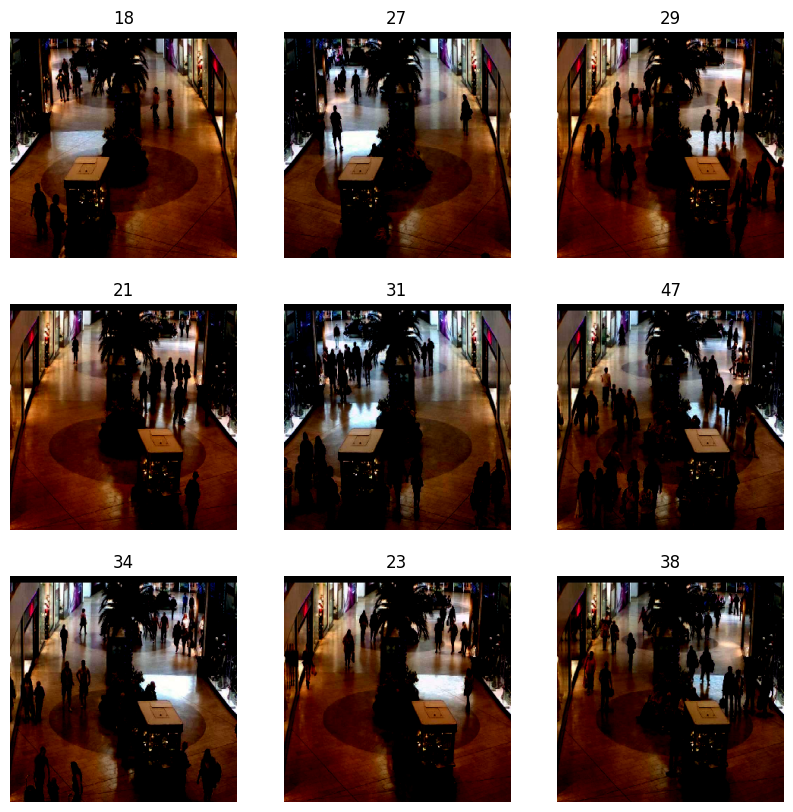

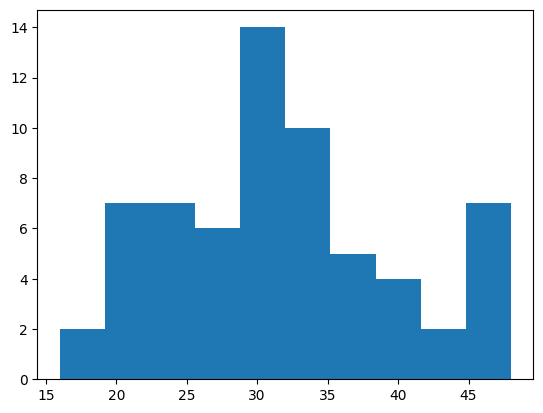

In [ ]:
xception_with_data_augmentation.visualize_data()

In [ ]:
xception_with_data_augmentation.prepare_model()
xception_with_data_augmentation.unfreeze_n_layers(15)
xception_with_data_augmentation.compile_model(
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.001),
)

In [ ]:
history_xception_data_augmentation = xception_with_data_augmentation.fit(
    epochs_=50,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=6
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                xception_with_data_augmentation.name,
                xception_with_data_augmentation.name
            ),
            save_weights_only=True
        )
    ]
)

Epoch 1/50
20/20 [==============================] - 24s 813ms/step - loss: 222.1949 - mse: 222.1949 - mae: 11.1844 - val_loss: 3353.4858 - val_mse: 3353.4858 - val_mae: 57.4402 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 18s 843ms/step - loss: 24.8786 - mse: 24.8786 - mae: 3.8972 - val_loss: 1145.7965 - val_mse: 1145.7965 - val_mae: 33.4745 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 16s 776ms/step - loss: 16.2948 - mse: 16.2948 - mae: 3.2115 - val_loss: 269.2946 - val_mse: 269.2946 - val_mae: 15.9299 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 16s 795ms/step - loss: 14.9706 - mse: 14.9706 - mae: 3.0787 - val_loss: 69.4811 - val_mse: 69.4811 - val_mae: 7.5664 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 16s 784ms/step - loss: 15.9650 - mse: 15.9650 - mae: 3.1546 - val_loss: 18.1357 - val_mse: 18.1357 - val_mae: 3.5185 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 16s 767ms/step - loss:

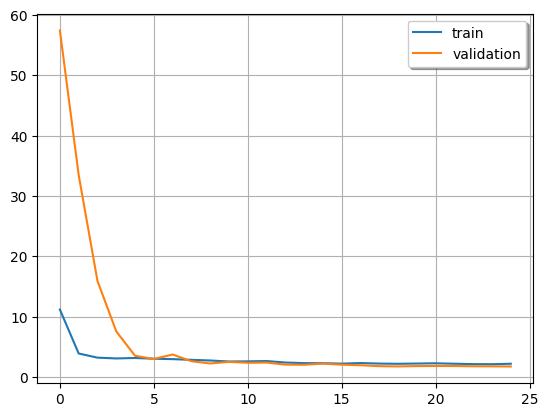

In [ ]:
plot_history(history_xception_data_augmentation, 'mae')

In [ ]:
history_xception_data_augmentation.model.evaluate(
    xception_with_data_augmentation.validation_generator
)

5/5 [==============================] - 3s 516ms/step - loss: 4.9280 - mse: 4.9280 - mae: 1.7691


[4.927992343902588, 4.927992343902588, 1.7690998315811157]

In [ ]:
save_history(
    history_xception_data_augmentation,
    os.path.join(
        manager.models_trial_path,
        f'{xception_with_data_augmentation.name}.csv'
    )
)

## Xception with data augmentation and more layers

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionDataAugmentationMoreLayersModel(XceptionModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        print(f'In Xception with data augmentation')
        self.data_generator_parameters = dict(
            rescale=None,
            horizontal_flip=True,
            # height_shift_range=0.1,
            preprocessing_function=\
                tf.\
                keras.\
                applications.\
                xception.\
                preprocess_input
        )

    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
xception_with_data_augmentation_3_layers = XceptionDataAugmentationMoreLayersModel(
    name_='xception_data_augmentation_3_layers',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

In Xception with data augmentation
Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
xception_with_data_augmentation_3_layers.prepare_model()
xception_with_data_augmentation_3_layers.unfreeze_n_layers(15)
xception_with_data_augmentation_3_layers.compile_model(
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.001),
)

In [ ]:
history_xception_with_data_augmentation_3_layers = xception_with_data_augmentation_3_layers.fit(
    epochs_=50,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=6
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                xception_with_data_augmentation_3_layers.name,
                xception_with_data_augmentation_3_layers.name
            ),
            save_weights_only=True
        )
    ]
)

In [ ]:
plot_history(history_xception_with_data_augmentation_3_layers, 'mae')

In [ ]:
history_xception_with_data_augmentation_3_layers.model.evaluate(
    xception_with_data_augmentation_3_layers.validation_generator
)

In [ ]:
save_history(
    history_xception_with_data_augmentation_3_layers,
    os.path.join(
        manager.models_trial_path,
        f'{xception_with_data_augmentation_3_layers.name}.csv'
    )
)

## Xception with correct transfer learning (A. Geron),more layers and ELU activation

### Define and train the model

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionModelGeronExperiment(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):

        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.xception.preprocess_input,
            horizontal_flip=True
        )

    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='relu', kernel_initializer='he_normal')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

    def fit(
        self,
        epochs_,
        epochs_initial_,
        callbacks_,
        n_unfreeze_initial_,
        n_unfreeze_final_,
        optimizer_initial_=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
        optimizer_final_=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
    ):
        print(f'Running custom fit')
        print(f'Unfreezing {n_unfreeze_initial_} layers')
        self.unfreeze_n_layers(n_unfreeze_initial_)
        self.compile_model(optimizer_=optimizer_initial_)

        history_initial = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_initial_,
            callbacks=[]
        )

        print(f'Unfreezing {n_unfreeze_final_} layers')
        self.unfreeze_n_layers(n_unfreeze_final_)
        self.compile_model(optimizer_=optimizer_final_)

        self.learning_history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        return self.learning_history

In [ ]:
xception_geron_experiment = XceptionModelGeronExperiment(
    name_='xception_geron_pretrain_best',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=32,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
xception_geron_experiment.prepare_model()

In [ ]:
history_geron_experiment = xception_geron_experiment.fit(
    epochs_=50,
    epochs_initial_=5,
    callbacks_=[
        EarlyStopping(
            monitor='val_mae',
            mode='min',
            patience=5
        ),
        ReduceLROnPlateau(
        monitor='val_mae',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                xception_geron_experiment.name,
                xception_geron_experiment.name
            ),
            save_weights_only=True,
        )
    ],
    n_unfreeze_initial_=7,
    n_unfreeze_final_=22,
    optimizer_initial_=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    optimizer_final_=tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
)

Running custom fit
Unfreezing 7 layers
Epoch 1/5
40/40 [==============================] - 18s 387ms/step - loss: 118.1394 - mse: 118.1394 - mae: 8.0553 - val_loss: 37.6475 - val_mse: 37.6475 - val_mae: 4.8090
Epoch 2/5
40/40 [==============================] - 14s 354ms/step - loss: 35.9851 - mse: 35.9851 - mae: 4.7313 - val_loss: 17.3099 - val_mse: 17.3099 - val_mae: 3.2904
Epoch 3/5
40/40 [==============================] - 14s 356ms/step - loss: 25.5550 - mse: 25.5550 - mae: 4.0626 - val_loss: 13.8602 - val_mse: 13.8602 - val_mae: 2.9697
Epoch 4/5
40/40 [==============================] - 17s 415ms/step - loss: 19.9640 - mse: 19.9640 - mae: 3.5505 - val_loss: 12.3211 - val_mse: 12.3211 - val_mae: 2.8138
Epoch 5/5
40/40 [==============================] - 14s 349ms/step - loss: 21.2845 - mse: 21.2845 - mae: 3.6865 - val_loss: 11.6154 - val_mse: 11.6154 - val_mae: 2.6431
Unfreezing 22 layers
Epoch 1/50
40/40 [==============================] - 20s 414ms/step - loss: 26.4474 - mse: 26.4474 

In [ ]:
xception_geron_experiment.model.evaluate(
    xception_geron_experiment.validation_generator
)

10/10 [==============================] - 3s 254ms/step - loss: 4.2407 - mse: 4.2407 - mae: 1.6127


[4.240740776062012, 4.240740776062012, 1.612727403640747]

### Save history

In [ ]:
xception_geron_experiment.name = 'xception_geron_pretrain_best'

In [ ]:
save_history(
    history_geron_experiment,
    os.path.join(
        manager.models_trial_path,
        f'{xception_geron_experiment.name}.csv'
    )
)

(32, 299, 299, 3) 1.0 -1.0
1/1 [==============================] - 1s 983ms/step


<class 'numpy.ndarray'> (32, 1)


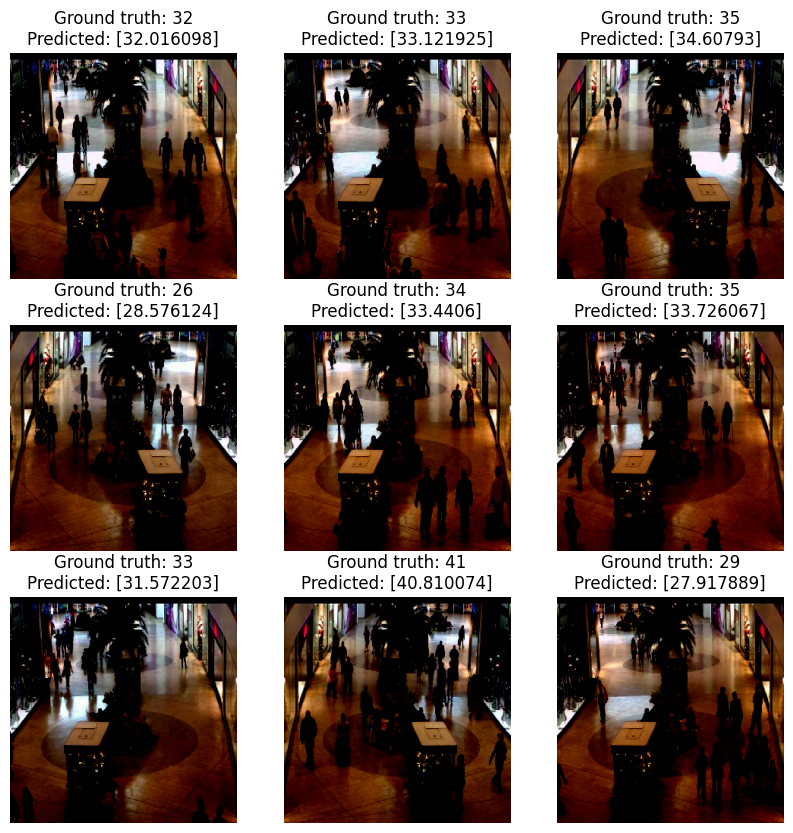

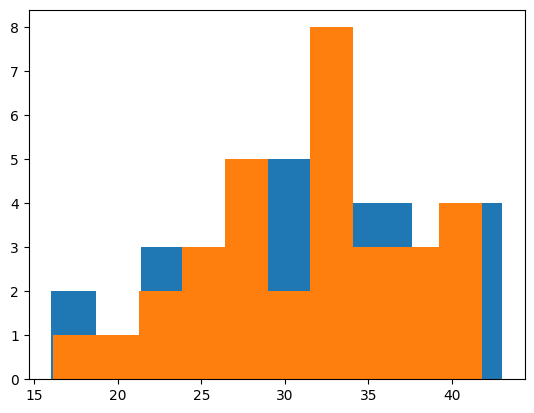

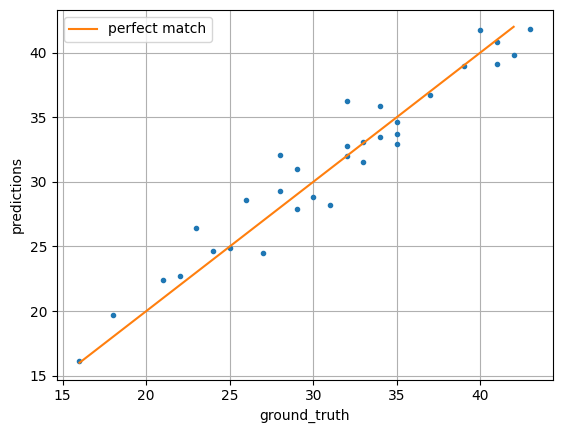

In [ ]:
visualize_predictions(
    xception_geron_experiment.model,
    xception_geron_experiment.validation_generator
)